In [1]:
import json
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
from sklearn.feature_extraction.text import CountVectorizer as countvec
from sklearn.cluster import KMeans as km
from sklearn.cluster import AgglomerativeClustering as hi
import scipy.cluster.hierarchy as hierarchy
from sklearn import mixture
from sklearn.metrics import silhouette_score as ss
from sklearn.metrics.pairwise import pairwise_distances as pairdist
from sklearn import preprocessing
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# get longitude and latitude of each business_id, also with its categories
business = []
for row in open('business.json'):
    row = json.loads(row)
    if 'Restaurants' in row['categories'] and row['city'] == 'Las Vegas':
        business.append({'business_id':row['business_id'], 'longitude':row['longitude'],'latitude':row['latitude'],
                        'categories':row['categories'],'stars':row['stars'],'review_count':row['review_count'],
                        'neighborhood':row['neighborhood']})
business = DF(business)
business.head(5)

,business_id,categories,latitude,longitude,neighborhood,review_count,stars
0,Pd52CjgyEU3Rb8co6QfTPw,"[Nightlife, Bars, Barbeque, Sports Bars, Ameri...",36.066914,-115.170848,Southeast,13,4.0
1,4srfPk1s8nlm1YusyDUbjg,"[Fast Food, Restaurants, Sandwiches]",36.064652,-115.118954,Southeast,6,2.5
2,n7V4cD-KqqE3OXk0irJTyA,"[Arcades, Arts & Entertainment, Gastropubs, Re...",36.068259,-115.178877,Southeast,349,3.0
3,F0fEKpTk7gAmuSFI0KW1eQ,"[Italian, Restaurants]",36.111057,-115.241688,Spring Valley,3,1.5
4,Wpt0sFHcPtV5MO9He7yMKQ,"[Restaurants, Fast Food, Burgers]",36.130013,-115.109310,Eastside,20,2.0


In [3]:
business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5899 entries, 0 to 5898
Data columns (total 7 columns):
business_id     5899 non-null object
categories      5899 non-null object
latitude        5899 non-null float64
longitude       5899 non-null float64
neighborhood    5899 non-null object
review_count    5899 non-null int64
stars           5899 non-null float64
dtypes: float64(3), int64(1), object(3)
memory usage: 322.7+ KB


In [4]:
biz = business.drop('stars',axis=1)
biz.head()

,business_id,categories,latitude,longitude,neighborhood,review_count
0,Pd52CjgyEU3Rb8co6QfTPw,"[Nightlife, Bars, Barbeque, Sports Bars, Ameri...",36.066914,-115.170848,Southeast,13
1,4srfPk1s8nlm1YusyDUbjg,"[Fast Food, Restaurants, Sandwiches]",36.064652,-115.118954,Southeast,6
2,n7V4cD-KqqE3OXk0irJTyA,"[Arcades, Arts & Entertainment, Gastropubs, Re...",36.068259,-115.178877,Southeast,349
3,F0fEKpTk7gAmuSFI0KW1eQ,"[Italian, Restaurants]",36.111057,-115.241688,Spring Valley,3
4,Wpt0sFHcPtV5MO9He7yMKQ,"[Restaurants, Fast Food, Burgers]",36.130013,-115.109310,Eastside,20


In [5]:
lati=business['latitude'].values
longi=business['longitude'].values

In [6]:
# load review json file
review = []
for r in open('review.json'):
    line = json.loads(r)
    review.append({'business_id':line['business_id'], 'text':line['text'], 'date':line['date'], 
                   'stars':line['stars'], 'review_id':line['review_id']})
review = DF(review)

In [7]:
review.head()

,business_id,date,review_id,stars,text
0,0W4lkclzZThpx3V65bVgig,2016-05-28,v0i_UHJMo_hPBq9bxWvW4w,5,"Love the staff, love the meat, love the place...."
1,AEx2SYEUJmTxVVB18LlCwA,2016-05-28,vkVSCC7xljjrAI4UGfnKEQ,5,Super simple place but amazing nonetheless. It...
2,VR6GpWIda3SfvPC-lg9H3w,2016-05-28,n6QzIUObkYshz4dz2QRJTw,5,Small unassuming place that changes their menu...
3,CKC0-MOWMqoeWf6s-szl8g,2016-05-28,MV3CcKScW05u5LVfF6ok0g,5,Lester's is located in a beautiful neighborhoo...
4,ACFtxLv8pGrrxMm6EgjreA,2016-05-28,IXvOzsEMYtiJI0CARmj77Q,4,Love coming here. Yes the place always needs t...


In [8]:
# concatenate reviews with the business_id
data_tmp = pd.merge(review,biz)
data_tmp.head(5)

,business_id,date,review_id,stars,text,categories,latitude,longitude,neighborhood,review_count
0,9Jc3W0aR9Xf2gcHI0rEXsw,2012-08-23,QgSf2JvYz-M4PU2yuJjxNQ,1,"After being scared away from Rock & Rita's, we...","[American (Traditional), Pub Food, Fast Food, ...",36.136978,-115.163337,The Strip,57
1,9Jc3W0aR9Xf2gcHI0rEXsw,2013-07-09,Pj41wBNrL1TPM0aKwqGNgQ,2,Came here for dinner b/c we arrived at the hot...,"[American (Traditional), Pub Food, Fast Food, ...",36.136978,-115.163337,The Strip,57
2,9Jc3W0aR9Xf2gcHI0rEXsw,2013-07-08,D7YruuihDlR2ASh1vvankw,2,There is no more prime rib. According to the w...,"[American (Traditional), Pub Food, Fast Food, ...",36.136978,-115.163337,The Strip,57
3,9Jc3W0aR9Xf2gcHI0rEXsw,2008-11-24,s8j02t2pcqtGzZTwRwYsHA,5,The Garden Grill is located inside the Circus ...,"[American (Traditional), Pub Food, Fast Food, ...",36.136978,-115.163337,The Strip,57
4,9Jc3W0aR9Xf2gcHI0rEXsw,2013-02-09,qC6VnDrkxOLEP4hyvtiwqg,4,All you can eat Prime Rib was DELICIOUS!!!!!! ...,"[American (Traditional), Pub Food, Fast Food, ...",36.136978,-115.163337,The Strip,57


In [9]:
data_tmp['year'], data_tmp['rest'] = data_tmp['date'].str.split('-', 1).str

In [10]:
data_tmp['month'], data_tmp['new_date'] = data_tmp['rest'].str.split('-', 1).str

In [11]:
data_tmp.drop('rest', axis=1, inplace=True)

In [56]:
data_tmp.head(500)
len(data_tmp)

929606

In [87]:
rc = data_tmp['review_count'] > 4000
new_data_tmp = data_tmp[rc]
new_data_tmp.head()

,business_id,date,review_id,stars,text,categories,latitude,longitude,neighborhood,review_count,year,month,new_date
37402,f4x1YBxkLrZg652xt2KR5g,2016-06-22,sqX-4E1wsfW9CE6-RFwKmw,4,"I'd been to the Hash House downtown, but not t...","[American (New), Restaurants, Breakfast & Brunch]",36.118181,-115.17158,The Strip,4774,2016,06,22
37403,f4x1YBxkLrZg652xt2KR5g,2017-07-12,sD0KL4CwBVceyO0Nc8Y6Yw,4,The portions are huge the food is delicious. M...,"[American (New), Restaurants, Breakfast & Brunch]",36.118181,-115.17158,The Strip,4774,2017,07,12
37404,f4x1YBxkLrZg652xt2KR5g,2014-03-13,gwF_GdU-AvWZp1Bbynmhgw,2,"Overrated! Went here for brunch, told 30 minu...","[American (New), Restaurants, Breakfast & Brunch]",36.118181,-115.17158,The Strip,4774,2014,03,13
37405,f4x1YBxkLrZg652xt2KR5g,2012-10-29,AMo5Nk8GAgm0OhQrnNm01A,4,"I have been to all the HHGGs in town, and fina...","[American (New), Restaurants, Breakfast & Brunch]",36.118181,-115.17158,The Strip,4774,2012,10,29
37406,f4x1YBxkLrZg652xt2KR5g,2011-12-30,DNivSyKQ8OmYwCQWwmUQJw,5,"Holy cow. Where do I start?\nFirst of all, I h...","[American (New), Restaurants, Breakfast & Brunch]",36.118181,-115.17158,The Strip,4774,2011,12,30


In [88]:
newdata = new_data_tmp.drop('review_id', axis=1)
newdata = newdata.drop('text', axis=1)
newdata = newdata.drop('latitude', axis=1)
newdata = newdata.drop('longitude', axis=1)
newdata = newdata.drop('neighborhood', axis=1)
newdata.head()

,business_id,date,stars,categories,review_count,year,month,new_date
37402,f4x1YBxkLrZg652xt2KR5g,2016-06-22,4,"[American (New), Restaurants, Breakfast & Brunch]",4774,2016,06,22
37403,f4x1YBxkLrZg652xt2KR5g,2017-07-12,4,"[American (New), Restaurants, Breakfast & Brunch]",4774,2017,07,12
37404,f4x1YBxkLrZg652xt2KR5g,2014-03-13,2,"[American (New), Restaurants, Breakfast & Brunch]",4774,2014,03,13
37405,f4x1YBxkLrZg652xt2KR5g,2012-10-29,4,"[American (New), Restaurants, Breakfast & Brunch]",4774,2012,10,29
37406,f4x1YBxkLrZg652xt2KR5g,2011-12-30,5,"[American (New), Restaurants, Breakfast & Brunch]",4774,2011,12,30


In [89]:
newdata = newdata.drop('review_count', axis=1)
newdata = newdata.drop('categories', axis=1)
# newdata.sort_values(by='year')
# newdata.index = newdata['date']
newdata.sort_values(by='date',inplace=True)
# n = newdata.head(100)

In [90]:
newdata.head(5)

,business_id,date,stars,year,month,new_date
172280,4JNXUYY8wbaaDmk3BPzlWw,2005-10-10,5,2005,10,10
174607,4JNXUYY8wbaaDmk3BPzlWw,2005-10-15,5,2005,10,15
170490,4JNXUYY8wbaaDmk3BPzlWw,2005-12-02,4,2005,12,02
173821,4JNXUYY8wbaaDmk3BPzlWw,2006-01-07,4,2006,01,07
170666,4JNXUYY8wbaaDmk3BPzlWw,2006-01-31,5,2006,01,31


In [117]:
# n = newdata.groupby(['business_id','year'], as_index=False)['stars'].mean()
# n.head()

In [118]:
# cnt = 0
# # fig, ax = plt.subplots(figsize=(8,6))
# for title, group in n.groupby('business_id'):
#     cnt += 1
#     group.plot(x='year', y='stars')

In [119]:
# print(cnt)

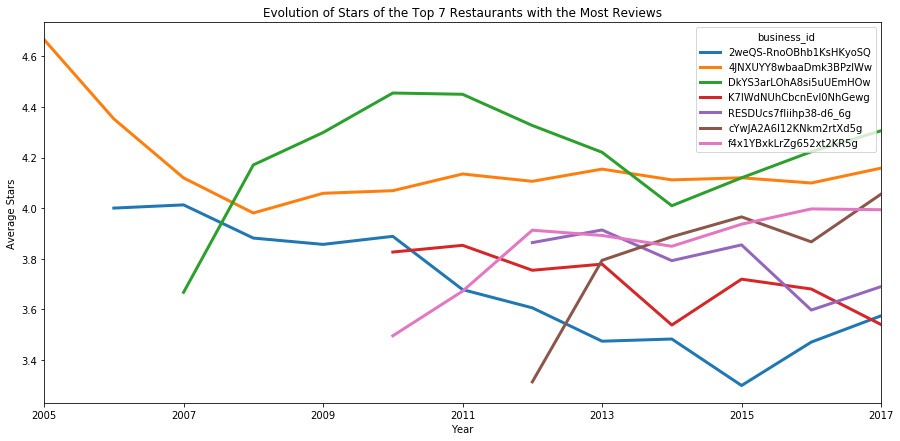

In [139]:
# plot data
fig, ax = plt.subplots(figsize=(15,7))
# use unstack()
newdata.groupby(['year','business_id']).mean()['stars'].unstack().plot(ax=ax,lw=3.0,ls='-')
plt.xlabel('Year')
plt.ylabel('Average Stars')
plt.title('Evolution of Stars of the Top 7 Restaurants with the Most Reviews')
plt.show()

In [141]:
n = newdata.groupby(['business_id','year'], as_index=False)['stars'].mean()
n.head()

,business_id,year,stars
0,2weQS-RnoOBhb1KsHKyoSQ,2006,4.000000
1,2weQS-RnoOBhb1KsHKyoSQ,2007,4.012658
2,2weQS-RnoOBhb1KsHKyoSQ,2008,3.881356
3,2weQS-RnoOBhb1KsHKyoSQ,2009,3.856397
4,2weQS-RnoOBhb1KsHKyoSQ,2010,3.888235


In [230]:
dx1=[]
dy1=[]
dx2=[]
dy2=[]
for x, y in n.groupby('business_id'):
    if x == 'K7lWdNUhCbcnEvI0NhGewg':
        dx1.append(y['year'])
        dy1.append(y['stars'])
    elif x == 'f4x1YBxkLrZg652xt2KR5g':
        dx2.append(y['year'])
        dy2.append(y['stars'])
dx1 = dx1[0]
dy1 = dy1[0]
dx2 = dx2[0]
dy2 = dy2[0]

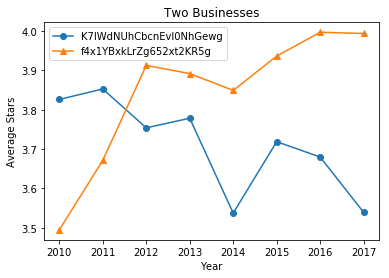

In [282]:
# plt.plot(dx1,dy1,'ro', label='$y = numbers', dx2,dy2,'g^')
# ax.legend()
# plt.show()
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(dx1, dy1, '-o', label='K7lWdNUhCbcnEvI0NhGewg')
ax.plot(dx2, dy2, '-^', label='f4x1YBxkLrZg652xt2KR5g')
plt.xlabel('Year')
plt.ylabel('Average Stars')
plt.title('Two Businesses')
ax.legend()
plt.show()

In [271]:
y2 = dy2.values
y1 = dy1.values
distances = np.zeros((len(y2), len(y1)))
distances

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [272]:
for i in range(len(y2)):
    for j in range(len(y1)):
#         distances[i,j] = (y1[j]-y2[i])**2  
        distances[i,j] = abs(y1[j]-y2[i])

In [273]:
distances

array([[ 0.33140611,  0.35797354,  0.25931276,  0.28362104,  0.04269726,
         0.22410856,  0.18509443,  0.04455966],
       [ 0.15473864,  0.18130607,  0.0826453 ,  0.10695357,  0.1339702 ,
         0.04744109,  0.00842697,  0.13210781],
       [ 0.08644949,  0.05988206,  0.15854283,  0.13423456,  0.37515833,
         0.19374704,  0.23276116,  0.37329594],
       [ 0.0656007 ,  0.03903327,  0.13769405,  0.11338577,  0.35430954,
         0.17289825,  0.21191238,  0.35244715],
       [ 0.02283391,  0.00373352,  0.09492725,  0.07061898,  0.31154275,
         0.13013146,  0.16914558,  0.30968036],
       [ 0.11015109,  0.08358366,  0.18224443,  0.15793616,  0.39885993,
         0.21744864,  0.25646276,  0.39699754],
       [ 0.17065217,  0.14408474,  0.24274552,  0.21843724,  0.45936102,
         0.27794972,  0.31696385,  0.45749862],
       [ 0.16748906,  0.14092163,  0.23958241,  0.21527413,  0.4561979 ,
         0.27478661,  0.31380074,  0.45433551]])

In [274]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.xlabel("K7lWdNUhCbcnEvI0NhGewg")
    plt.ylabel("f4x1YBxkLrZg652xt2KR5g")
    plt.grid()
    plt.colorbar();

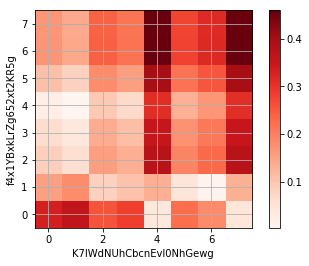

In [275]:
distance_cost_plot(distances)

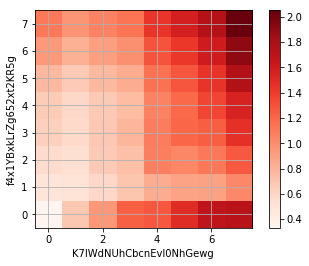

In [277]:
# Warping Path Calculations
accumulated_cost = np.zeros((len(y2), len(y1)))
accumulated_cost[0,0] = distances[0,0]
for i in range(1, len(y1)):
    accumulated_cost[0,i] = distances[0,i] + accumulated_cost[0, i-1] 
for i in range(1, len(y2)):
    accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]  
# Accumulated Cost (D(i,j))=min{D(i−1,j−1),D(i−1,j),D(i,j−1)}+distance(i,j)
for i in range(1, len(y2)):
    for j in range(1, len(y1)):
        accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
distance_cost_plot(accumulated_cost)

In [278]:
# Backtracking and finding the optimal warp path
path = [[len(y1)-1, len(y2)-1]]
i = len(y2)-1
j = len(y1)-1
while i>0 and j>0:
    if i==0:
        j = j - 1
    elif j==0:
        i = i - 1
    else:
        if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            i = i - 1
        elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
            j = j-1
        else:
            i = i - 1
            j= j- 1
    path.append([j, i])
path.append([0,0])

In [279]:
path

[[7, 7],
 [6, 6],
 [5, 5],
 [4, 4],
 [3, 4],
 [2, 4],
 [1, 3],
 [1, 2],
 [0, 1],
 [0, 0]]

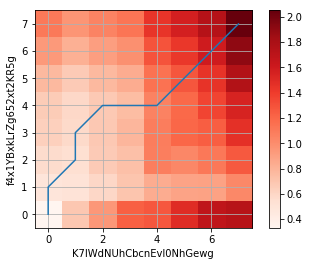

In [280]:
path_y1 = [point[0] for point in path]
path_y2 = [point[1] for point in path]
distance_cost_plot(accumulated_cost)
plt.plot(path_y1, path_y2);